In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import cast

df_raw = pd.read_csv('export.csv', dtype={"trackable_id": "str"})

In [ ]:
df_raw.head() 

,user_id,age,sex,country,checkin_date,trackable_id,trackable_type,trackable_name,trackable_value
0,QEVuQwEABlEzkh7fsBBjEe26RyIVcg==,NaN,NaN,NaN,2015-11-26,1069,Condition,Ulcerative colitis,0
1,QEVuQwEAWRNGnuTRqXG2996KSkTIEw==,32.0,male,US,2015-11-26,1069,Condition,Ulcerative colitis,0
2,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3168,Condition,pain in left upper arm felt like i was getting...,4
3,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3169,Condition,hip pain when gettin up,3
4,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3170,Condition,pain in hand joints,4


In [3]:
# Clean data
df_raw["age"] = df_raw.age.replace(0.0,np.nan)

threshold = 100 # Anything that occurs less than this will be removed.
value_counts = df_raw.stack().value_counts() # Entire DataFrame 
print(value_counts)
#to_remove = value_counts[value_counts <= threshold].index
#df_raw.replace(to_remove, np.nan, inplace=True)


female                           6478402
US                               4690209
Symptom                          3642279
Weather                          1393855
0                                1385241
                                  ...   
Mold Allergy                           1
chocolate peanutbutter candy           1
peanutbutter chocolate cookie          1
bluberry muffin                        1
poor productivity                      1
Name: count, Length: 399203, dtype: int64


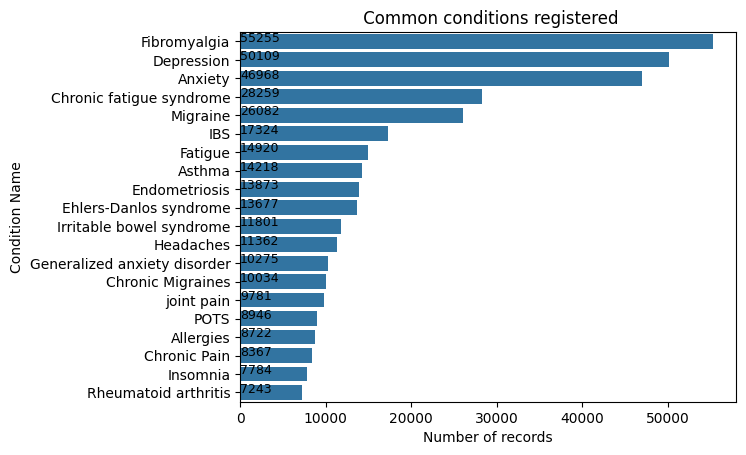

In [4]:
#plt.figure(figsize=(15,15))
sector_name = df_raw[df_raw.trackable_type=="Condition"].trackable_name.value_counts().iloc[0:20]
sns.barplot(x=sector_name.values, y=sector_name.index)
for i, v in enumerate(sector_name.values):
    plt.text(0.8,i,v,color='k',fontsize=9)
plt.xticks(rotation='horizontal')
plt.xlabel('Number of records')
plt.ylabel('Condition Name')
plt.title(" Common conditions registered")
plt.show()

Split df in by (top 10) conditions
- If a row exists with a given (user, date) pair and a condition name within those top 10,
    then the new df created for that condition should include all non-condition trackable type rows with the same (user, date) pair

- for each non-condition trackable type with NaN type for trackable_value:
    - take top 100 unique names and store 3-grams tokenizations of said names (for use in similarity encoding, see below link)
    
for each df per condition, goal is to have one row per (user, date):
- group by user, date
- remove trackable-name=condition row, place related value as condition_severity column
- take top 10 non-condition trackables with numerical trackable values and add as <type>_severity columns
- group NaN value trackables  (categorical variables) by type 
- - for each type, create 100 binary columns and encode similarity vector using 3-gram token similarity against previously stored top-100 names

https://arxiv.org/pdf/1806.00979.pdf



In [5]:
sector_name = df_raw[df_raw.trackable_type=="Condition"].trackable_name.value_counts().head(10)
for name in sector_name.index:
    print(name)

Fibromyalgia
Depression
Anxiety
Chronic fatigue syndrome
Migraine
IBS
Fatigue
Asthma
Endometriosis
Ehlers-Danlos syndrome


In [6]:
"""
- If a row exists with a given (user, date) pair and a condition name within those top 10,
    then the new df created for that condition should include all non-condition trackable type rows with the same (user, date) pair
"""
#dropping columns that are not required and not relevant to our study/project
df = df_raw.drop(columns =['age', 'sex', 'country'])
df.head()

#x = 0
##use this to insert new columns as per condition type
#newdf.insert(x, column, value, allow_duplicates=_NoDefault.no_default)
##increase count of x
#x +=1
#conditionname = "" # reset column name to zero

,user_id,checkin_date,trackable_id,trackable_type,trackable_name,trackable_value
0,QEVuQwEABlEzkh7fsBBjEe26RyIVcg==,2015-11-26,1069,Condition,Ulcerative colitis,0
1,QEVuQwEAWRNGnuTRqXG2996KSkTIEw==,2015-11-26,1069,Condition,Ulcerative colitis,0
2,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2017-04-28,3168,Condition,pain in left upper arm felt like i was getting...,4
3,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2017-04-28,3169,Condition,hip pain when gettin up,3
4,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2017-04-28,3170,Condition,pain in hand joints,4


In [7]:
#FIBROMYALGIA
fibromyalgia_df = df[df["trackable_name"] == "Fibromyalgia"]

,user_id,checkin_date,trackable_id,trackable_type,trackable_name,trackable_value
291,QEVuQwEAzZl+kJVQFj2hY5xrzOcbnA==,2015-05-25,397,Condition,Fibromyalgia,0
308,QEVuQwEA6PPwjZ8tnqC1KHhapbdMpQ==,2015-05-25,397,Condition,Fibromyalgia,2
347,QEVuQwEAT556zzFRIWMYQwW/SuVuQg==,2015-12-08,397,Condition,Fibromyalgia,1
363,QEVuQwEAT556zzFRIWMYQwW/SuVuQg==,2015-12-07,397,Condition,Fibromyalgia,1
465,QEVuQwEADFtnDHECcyAylMlv1pPa/Q==,2015-05-29,397,Condition,Fibromyalgia,2
...,...,...,...,...,...,...
7970462,QEVuQwEAFVXKnAhnXfnsY5rZ6GwGXA==,2019-11-27,397,Condition,Fibromyalgia,2
7970479,QEVuQwEAFVXKnAhnXfnsY5rZ6GwGXA==,2019-11-29,397,Condition,Fibromyalgia,2
7970496,QEVuQwEAFVXKnAhnXfnsY5rZ6GwGXA==,2019-11-30,397,Condition,Fibromyalgia,2
7970513,QEVuQwEAFVXKnAhnXfnsY5rZ6GwGXA==,2019-12-01,397,Condition,Fibromyalgia,2


In [29]:
keys = ['user_id', 'checkin_date']

i1 = df.set_index(keys).index
i2_df = fibromyalgia_df.set_index(keys)
i2_df.head()
agg_df = df[i1.isin(i2_df.index) & (df['trackable_type'] != 'Condition')]
print(agg_df.trackable_type.unique())
agg_df = agg_df[~((agg_df['trackable_value'] == '0') | (agg_df['trackable_value'] == '1') | (agg_df['trackable_value'] == '2')) \
    & (agg_df['trackable_type'] != 'Weather') \
    & (agg_df['trackable_type'] != 'HBI')]
agg_df = agg_df.drop(columns=['trackable_value', 'trackable_id', 'trackable_type'])
final_df = agg_df.join(i2_df['trackable_value'].rename('condition_severity'), on=keys)

['Symptom' 'Tag' 'Treatment' 'Food' 'Weather' 'HBI']


In [30]:
from skrub import GapEncoder

enc = GapEncoder(n_components=10, random_state=42)
X_dirty = final_df[['trackable_name']]
X_enc = enc.fit_transform(X_dirty)
print(f"Shape of encoded vectors = {X_enc.shape}")

Shape of encoded vectors = (533760, 10)


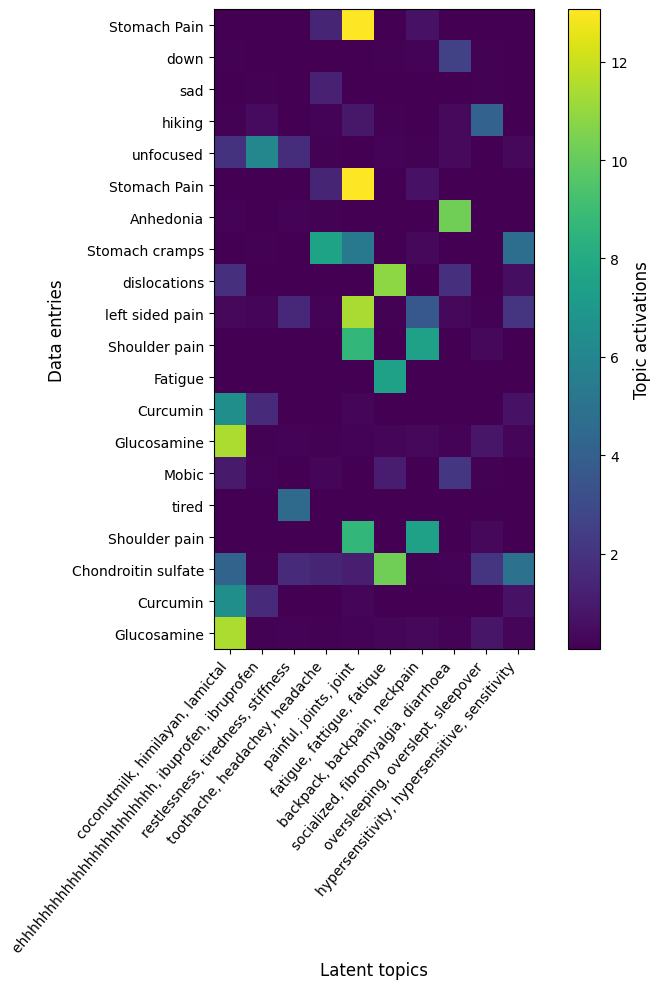

In [31]:
topic_labels = enc.get_feature_names_out(n_labels=3)
encoded_labels = enc.transform(X_dirty[:20])
plt.figure(figsize=(8, 10))
plt.imshow(encoded_labels)
plt.xlabel("Latent topics", size=12)
plt.xticks(range(0, 10), labels=topic_labels, rotation=50, ha="right")
plt.ylabel("Data entries", size=12)
plt.yticks(range(0, 20), labels=X_dirty[:20].to_numpy().flatten())
plt.colorbar().set_label(label="Topic activations", size=12)
plt.tight_layout()
plt.show()

In [47]:
from skrub import TableVectorizer, SelectCols 
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
regressor = RandomForestRegressor()
X = final_df[['user_id', 'checkin_date', 'trackable_name']]
y = final_df['condition_severity']
pipeline = make_pipeline(SelectCols('trackable_name'), TableVectorizer(n_jobs=-1, high_card_cat_transformer=GapEncoder(n_components=15, hashing=True)), regressor)
pipeline.fit(X, y)

Pipeline(steps=[('selectcols', SelectCols(cols='trackable_name')),
                ('tablevectorizer',
                 TableVectorizer(high_card_cat_transformer=GapEncoder(hashing=True,
                                                                      n_components=15),
                                 n_jobs=-1)),
                ('randomforestregressor', RandomForestRegressor())])

In [48]:
from pprint import pprint

# Recover the TableVectorizer from the Pipeline
tv = pipeline.named_steps["tablevectorizer"]

pprint(tv.transformers_)


[('high_card_cat',
  GapEncoder(hashing=True, n_components=15, n_jobs=-1),
  ['trackable_name'])]


In [49]:
feature_names = tv.get_feature_names_out()
print(len(feature_names))


15


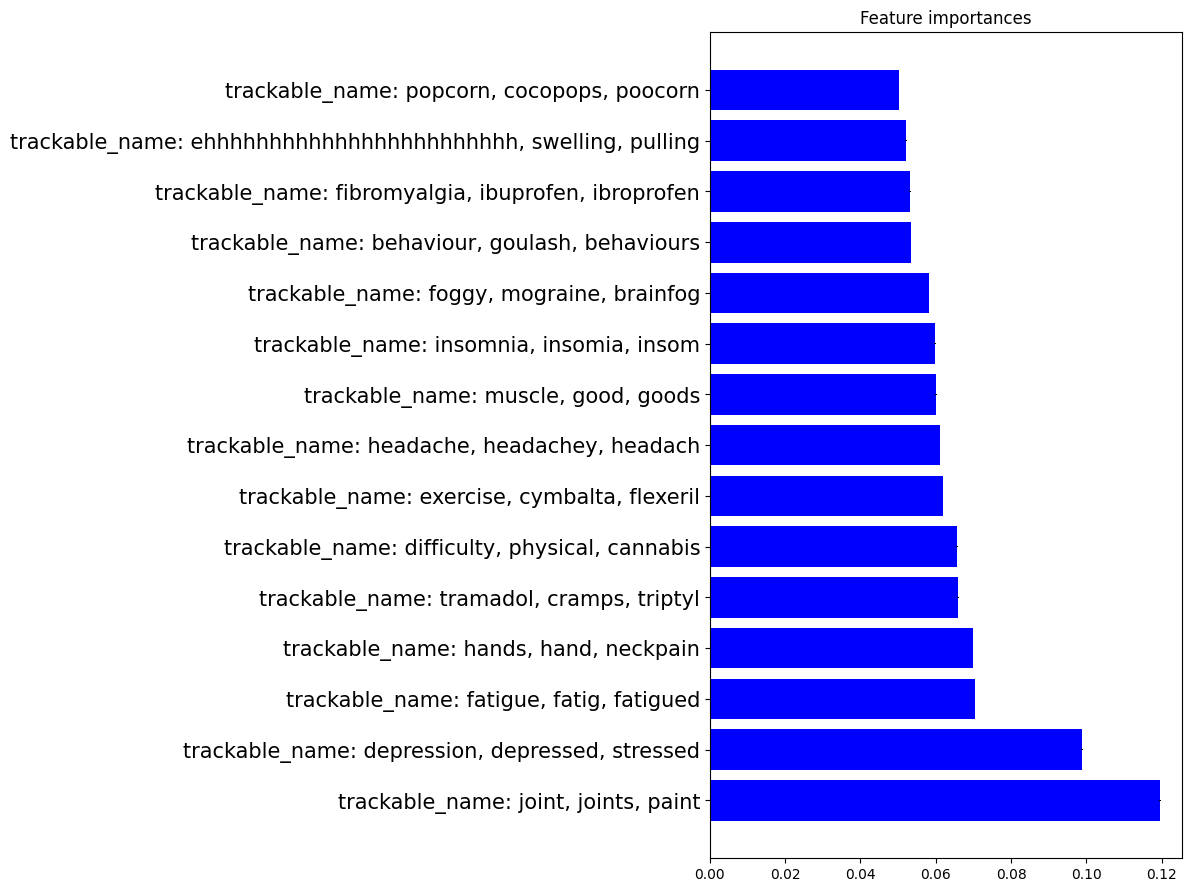

In [50]:
avg_importances = regressor.feature_importances_
std_importances = np.std(
    [tree.feature_importances_ for tree in regressor.estimators_], axis=0
)
indices = np.argsort(avg_importances)[::-1]

import matplotlib.pyplot as plt

top_indices = indices[:20]
labels = np.array(feature_names)[top_indices]

plt.figure(figsize=(12, 9))
plt.barh(
    y=labels,
    width=avg_importances[top_indices],
    yerr=std_importances[top_indices],
    color="b",
)
plt.yticks(fontsize=15)
plt.title("Feature importances")
plt.tight_layout(pad=1)
plt.show()

In [11]:
#DEPRESSION
depression_df = df[df["trackable_name"] == "Depression"]
depression_df.sort_values(by =['user_id'])
depression_df.head(10)

,user_id,checkin_date,trackable_id,trackable_type,trackable_name,trackable_value
72,QEVuQwEAt9BT8darNBUVXse2TEL3SA==,2015-07-17,54,Symptom,Depression,0
93,QEVuQwEAt9BT8darNBUVXse2TEL3SA==,2015-07-19,54,Symptom,Depression,0
110,QEVuQwEAt9BT8darNBUVXse2TEL3SA==,2015-08-10,54,Symptom,Depression,1
126,QEVuQwEAt9BT8darNBUVXse2TEL3SA==,2015-07-26,54,Symptom,Depression,0
135,QEVuQwEA6peEzOOIEaK2Ic9oHMBYjw==,2015-07-06,291,Condition,Depression,1
163,QEVuQwEAkEzdSCGIT4aSMUGksMXjug==,2015-07-06,291,Condition,Depression,1
194,QEVuQwEA08uRNqb7wltBMKWvJGIUwA==,2015-05-26,54,Symptom,Depression,3
208,QEVuQwEA08uRNqb7wltBMKWvJGIUwA==,2015-05-27,54,Symptom,Depression,1
227,QEVuQwEA66EJ4oOf7mD5xYzgc9nrSw==,2015-07-17,54,Symptom,Depression,0
248,QEVuQwEA66EJ4oOf7mD5xYzgc9nrSw==,2015-07-19,54,Symptom,Depression,0


In [12]:
#ANXIETY
anxiety_df = newdf[newdf["trackable_name"] == "Anxiety"]
anxiety_df.sort_values(by =['user_id'])
anxiety_df.head(10)

NameError: name 'newdf' is not defined

In [ ]:
#Chronic Fatigue Syndrome
cfs_df = newdf[newdf["trackable_name"] == "Chronic Fatigue Syndrome"]
cfs_df.sort_values(by =['user_id'])
cfs_df.head(10)

In [ ]:
#Migraine
migraine_df = newdf[newdf["trackable_name"] == "Migraine"]
migraine_df.sort_values(by =['user_id'])
migraine_df.head(10)

In [ ]:
#IBS
ibs_df = newdf[newdf["trackable_name"] == "IBS"]
ibs_df.sort_values(by =['user_id'])
ibs_df.head(10)

In [ ]:
#Fatigue
fatigue_df = newdf[newdf["trackable_name"] == "Fatigue"]
fatigue_df.sort_values(by =['user_id'])
fatigue_df.head(10)

In [ ]:
#Asthma
asthma_df = newdf[newdf["trackable_name"] == "Asthma"]
asthma_df.sort_values(by =['user_id'])
asthma_df.head(10)

In [ ]:
#Endometriosis
endometriosis_df = newdf[newdf["trackable_name"] == "Endometriosis"]
endometriosis_df.sort_values(by =['user_id'])
endometriosis_df.head(10)

In [ ]:
#EDS
eds_df = newdf[newdf["trackable_name"] == "Ehlers-Danlos syndrome"]
eds_df.sort_values(by =['user_id'])
eds_df.head(10)

In [ ]:
df.head()

In [ ]:
"""
- for each non-condition trackable type with NaN type for trackable_value:
    - take top 100 unique names and store 3-grams tokenizations of said names (for use in similarity encoding, see below link)
"""

newerdf = df[newdf["trackable_type"] != "Condition"]
newerdf = newerdf[newerdf["trackable_value"].isna()]
newerdf.head(10)

In [ ]:
token_name = newerdf.trackable_name.value_counts().iloc[0:100]
print(token_name)

## 